In [13]:
import cv2
import dlib

import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import skvideo.io

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams

from tqdm import tqdm

import glob
import json
from os.path import join, basename, exists
from os import listdir, makedirs
from collections import defaultdict

%matplotlib inline

In [2]:
rcParams['figure.figsize'] = (15, 15)

In [3]:
predictor_path = './models/shape_predictor_68_face_landmarks.dat'
face_rec_model_path = './models/dlib_face_recognition_resnet_model_v1.dat'

detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor(predictor_path)
facerec = dlib.face_recognition_model_v1(face_rec_model_path)

In [4]:
video_paths = [
    './data/faces/faces1.mp4',
    './data/faces/faces2.mp4',
    './data/faces/faces3.mp4',
    './data/faces/faces4.mp4'
]

In [5]:
def show_images(images, num_rows, num_cols, additional_info=None, colorbar=False):
#     num_cols = 6
#     num_rows = len(class_idxs) // num_cols + (1 if len(class_idxs) % num_cols != 0 else 0)
    plt.figure(figsize=(15, 15))
    gs = gridspec.GridSpec(num_rows, num_cols, top=1., bottom=0., right=1., left=0., hspace=0., wspace=0.0)

    for i in range(min(num_rows*num_cols, len(images))):
        image = images[i]
        if len(image.shape) >= 3:
            width, height, _ = image.shape
        else:
            width, height = image.shape
        if additional_info is not None:
            color = (0, 0, 255)
            dst = cv2.putText(image, str(additional_info[i]), (0, 400),
                          cv2.FONT_HERSHEY_SIMPLEX, width/254, (255, 255, 255), width//100, cv2.LINE_AA)
        else:
            dst = image

        ax = plt.subplot(gs[i])
        im = ax.imshow(dst, cmap='coolwarm', vmin=-15., vmax=15.)
        if colorbar:
            plt.colorbar(im, ax=ax)
        ax.set_xticks([])
        ax.set_yticks([])

In [6]:
def draw_detected_faces(img, dets):
    dst = img.copy()
    for d in dets:
        cv2.rectangle(dst, (d.left(), d.top()), (d.right(), d.bottom()), (0, 0, 255), 3)
    
    return dst

In [7]:
def add_face(face_descriptor, face_img, frame_idx, bbox, faces):
    if (face_img.shape[0] > 0) and (face_img.shape[1] > 0):
        face_img = cv2.resize(face_img, (48, 48))
        faces['frame_idxs'].append(frame_idx)
        faces['descriptors'].append(face_descriptor)
        faces['bboxes'].append(bbox)
        faces['face_imgs'].append(face_img)

def dump_faces(faces, dump_path):
    if len(faces) == 0:
        return
    
    frame_idxs = np.array(faces['frame_idxs'])[..., np.newaxis]
    face_descriptors = np.array(faces['descriptors'])
    bboxes = np.array(faces['bboxes'])
    face_images = np.array(list(map(lambda face_img: face_img.ravel(), faces['face_imgs'])))
    faces_matrix = np.hstack([frame_idxs, face_descriptors, bboxes, face_images])
    
    np.save(dump_path, faces_matrix)

In [8]:
def detect_faces_video(detector, video_path, out_path):
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    h, w = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    out = cv2.VideoWriter(out_path, fourcc, cap.get(cv2.CAP_PROP_FPS), (w, h))
    
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for i in tqdm(range(n_frames)):
        ok, frame = cap.read()

        if not ok:
            break

        frame = frame[..., ::-1]
        
        dets = detector(frame, 1)
        dets = [d.rect for d in dets]
        dst = draw_detected_faces(frame, dets)

        out.write(dst[..., ::-1])

    out.release()
    cap.release()

In [9]:
def collect_faces_video(detector, video_path, out_path):
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    h, w = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    out = cv2.VideoWriter(out_path, fourcc, cap.get(cv2.CAP_PROP_FPS), (w, h))
    
    faces = defaultdict(list)
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for i in tqdm(range(n_frames)):
        ok, frame = cap.read()

        if not ok:
            break

        frame = frame[..., ::-1]
        
        dets = detector(frame, 1)
        dets = [d.rect for d in dets]
        for d in dets:
            shape = sp(frame, d)
            face_descriptor = facerec.compute_face_descriptor(frame, shape)
            face_descriptor = np.array(face_descriptor)

            bbox = d.top(), d.left(), d.bottom(), d.right()
            face_img = frame[d.top():d.bottom(), d.left():d.right()]
            add_face(face_descriptor, face_img, i, bbox, faces)

        dst = draw_detected_faces(frame, dets)
        out.write(dst[..., ::-1])

    out.release()
    cap.release()
    
    return faces

In [10]:
cnn_face_detector = dlib.cnn_face_detection_model_v1('./models/mmod_human_face_detector.dat')

3000


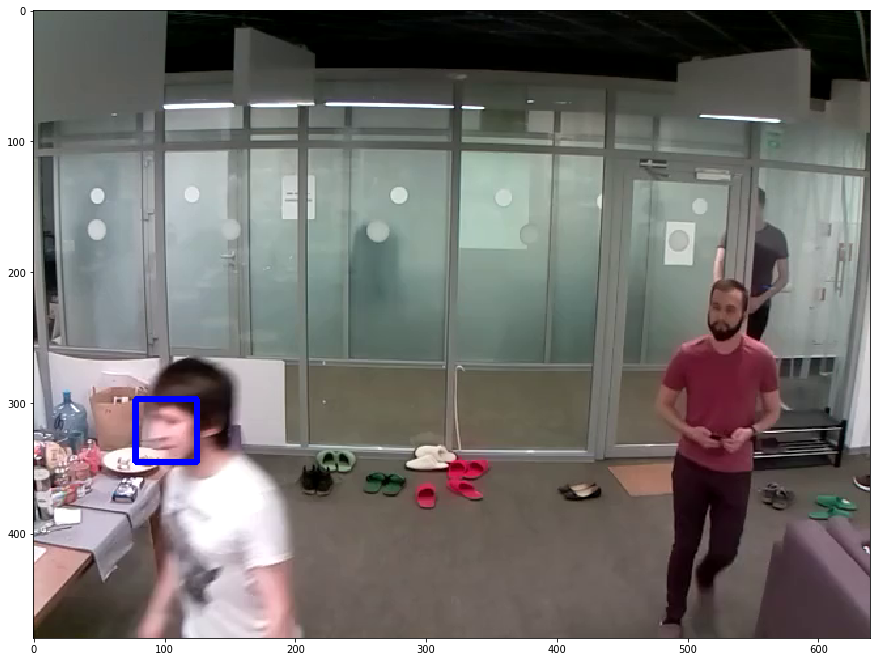

In [11]:
cap = cv2.VideoCapture(video_paths[3])
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(n_frames)
cap.set(1, 500)

_, img = cap.read()
img = img[..., ::-1]
cap.release()

dets = cnn_face_detector(img, 1)
dets = [d.rect for d in dets]
dst = draw_detected_faces(img, dets)
imshow(dst)

In [ ]:
detect_faces_video(cnn_face_detector, video_paths[3], './data/tmp.mp4')

In [36]:
faces = collect_faces_video(cnn_face_detector, video_paths[3], './data/tmp.mp4')

100%|██████████| 1000/1000 [01:57<00:00,  8.51it/s]


In [ ]:
face_descriptors = np.array(list(map(lambda face: face['descriptor'], faces)))

In [19]:
kmeans = KMeans(n_clusters=4)

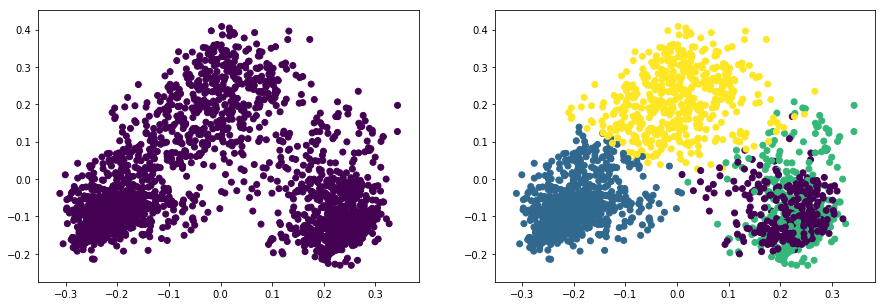

In [46]:
descriptors2d = PCA(n_components=2).fit_transform(face_descriptors)
colors = list(map(lambda face: face['id'], faces))
clusters = kmeans.fit_predict(face_descriptors)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].scatter(list(zip(*descriptors2d))[0], list(zip(*descriptors2d))[1], c=colors)
axes[1].scatter(list(zip(*descriptors2d))[0], list(zip(*descriptors2d))[1], c=clusters)

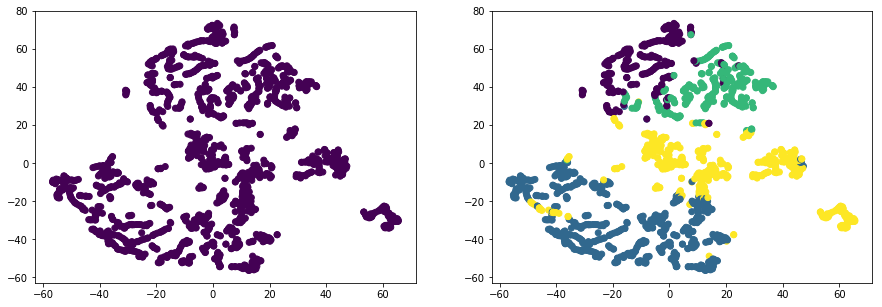

In [50]:
descriptors2d = TSNE(n_components=2).fit_transform(face_descriptors)
colors = list(map(lambda face: face['id'], faces))
clusters = kmeans.fit_predict(face_descriptors)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].scatter(list(zip(*descriptors2d))[0], list(zip(*descriptors2d))[1], c=colors)
axes[1].scatter(list(zip(*descriptors2d))[0], list(zip(*descriptors2d))[1], c=clusters)

In [51]:
clusters = kmeans.fit_predict(face_descriptors)

In [67]:
cl = 3
same_faces = [face['face_img'] for i, face in enumerate(faces) if clusters[i] == cl]
print(len(same_faces))

481


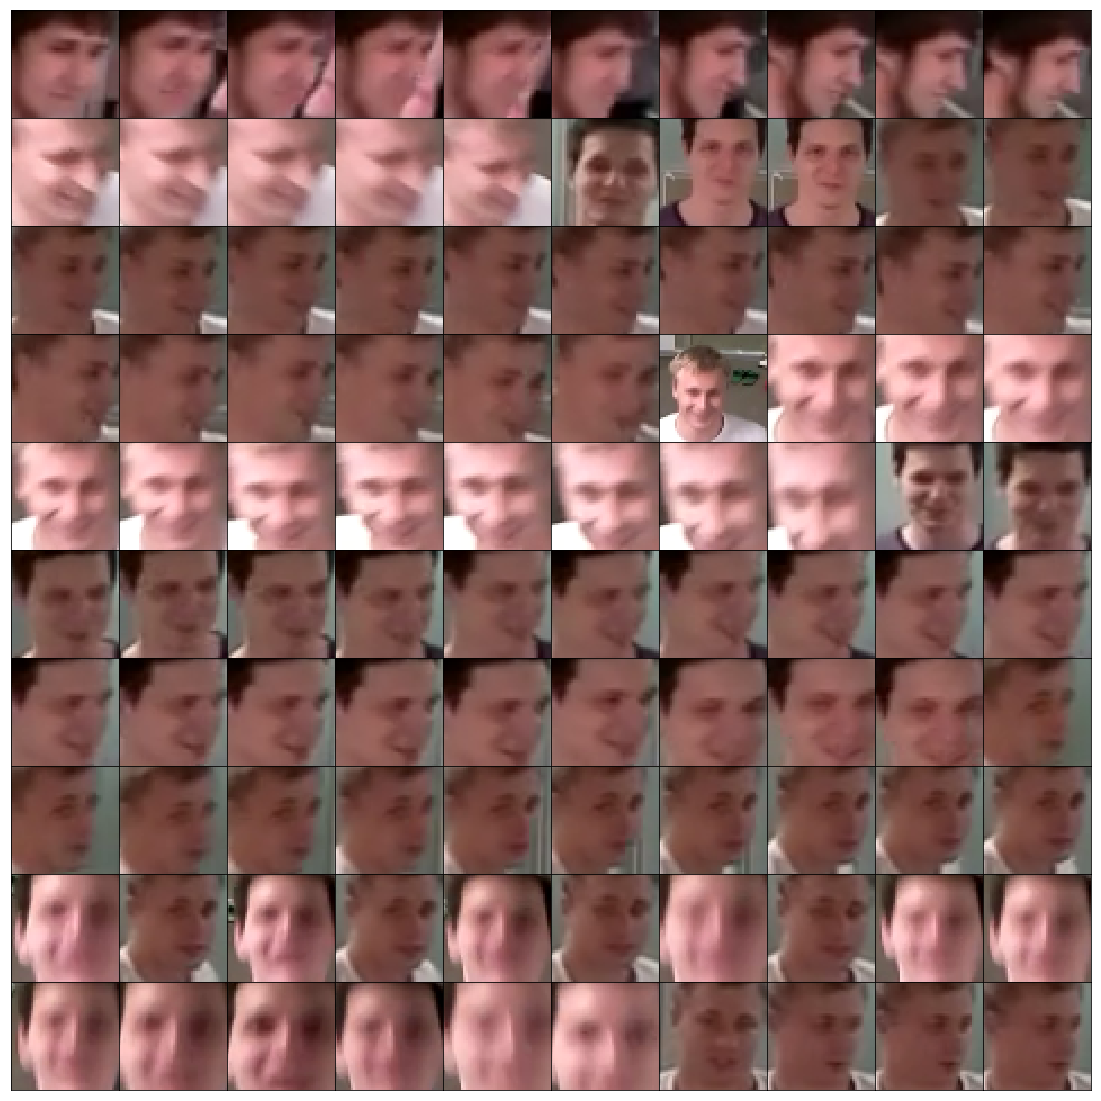

In [70]:
show_images(same_faces[200:], 10, 10)

## Dump faces from all videos

In [12]:
for i, video_path in enumerate(video_paths):
    print('Video {}/{}...'.format(i + 1, len(video_paths)))
    faces = collect_faces_video(cnn_face_detector, video_path, './data/tmp.mp4')
    dump_fname = basename(video_path)[:-4] + '.npy'
    dump_faces(faces, join('./descriptors/', dump_fname))

  0%|          | 1/4502 [00:00<10:03,  7.46it/s]

Video 0/4...


  0%|          | 1/3000 [00:00<05:35,  8.93it/s]

Video 1/4...


  0%|          | 1/2999 [00:00<05:38,  8.85it/s]

Video 2/4...


  0%|          | 1/3000 [00:00<05:39,  8.84it/s]

Video 3/4...


100%|██████████| 3000/3000 [06:00<00:00,  8.33it/s]


In [14]:
descr_paths = glob.glob('./descriptors/*')

In [15]:
all_descr = []
for descr_path in descr_paths:
    faces = np.load(descr_path)
    all_descr.append(faces[:, 1:129])
all_descr = np.vstack(all_descr)

In [17]:
np.save('./descriptors/all_descriptors.npy', all_descr)